# Emotion Detection

## Import libraries

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.tree import DecisionTreeClassifier
import nltk
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from lime.lime_text import IndexedString,IndexedCharacters
from lime.lime_base import LimeBase
from lime.lime_text import explanation




import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

#nltk.download("stopwords")
# stop_words = set(stopwords.words("english"))
# lemmatizer= WordNetLemmatizer()

# Modelling
from sklearn.model_selection import train_test_split,KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.svm import SVC

#Lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from lime.lime_text import IndexedString,IndexedCharacters
from lime.lime_base import LimeBase
from lime.lime_text import explanation

In [89]:
column_names = ['Text', 'Emotion']

train_data = pd.read_csv("train_data.csv")
test_data = pd.read_csv("test.tsv", delimiter='\t', header=None, names=column_names, quotechar='"')
# train_data.drop(0, inplace=True)

train_data

,Text,Emotion
0,کی گفته مرد گریه نمیکنه!؟!؟ سیلم امشب سیل #اصفهان,SAD
1,عکسی که چند روز پیش گذاشته بودم این فیلم الانش...,OTHER
2,تنهاییم شبیه تنهاییه ظهرای بچگیم شده وقتی که ه...,SAD
3,خوبه تمام قسمت‌های گوشی رو محافظت می‌کنه,HAPPY
4,این خاک مال مردمان است نه حاکمان #ایران #مهسا_...,ANGRY
...,...,...
4919,من از بو و ماندگاریش راضی بودم ، قیمتش هم‌ مناسبه,HAPPY
4920,گاز نداریم آب نداریم برق نداریم نت نداریم پول ...,SAD
4921,یکی بهم گفت برنو چرا عاشق نمیشی گفتم ما پول عا...,SAD
4922,زیادی داریم به قضیه ی گاز میپردازیم فقط فراخوا...,OTHER


In [90]:
print(train_data.shape)
print(test_data.shape)

(4924, 2)
(1151, 2)


In [97]:
train_data.info

<bound method DataFrame.info of                                                    Text Emotion
0     کی گفته مرد گریه نمیکنه!؟!؟ سیلم امشب سیل #اصفهان     SAD
1     عکسی که چند روز پیش گذاشته بودم این فیلم الانش...   OTHER
2     تنهاییم شبیه تنهاییه ظهرای بچگیم شده وقتی که ه...     SAD
3              خوبه تمام قسمت‌های گوشی رو محافظت می‌کنه   HAPPY
4     این خاک مال مردمان است نه حاکمان #ایران #مهسا_...   ANGRY
...                                                 ...     ...
4919  من از بو و ماندگاریش راضی بودم ، قیمتش هم‌ مناسبه   HAPPY
4920  گاز نداریم آب نداریم برق نداریم نت نداریم پول ...     SAD
4921  یکی بهم گفت برنو چرا عاشق نمیشی گفتم ما پول عا...     SAD
4922  زیادی داریم به قضیه ی گاز میپردازیم فقط فراخوا...   OTHER
4923  سلام. خیلی مواظبت کنید این ویروس کوفتی رو‌ نگی...     SAD

[4924 rows x 2 columns]>

In [98]:
train_data.describe()

,Text,Emotion
count,4924,4924
unique,4924,5
top,کی گفته مرد گریه نمیکنه!؟!؟ سیلم امشب سیل #اصفهان,HAPPY
freq,1,1462


In [99]:
# Check the balance
train_data.Emotion.value_counts()

Emotion
HAPPY    1462
OTHER    1263
ANGRY    1012
SAD       845
FEAR      342
Name: count, dtype: int64

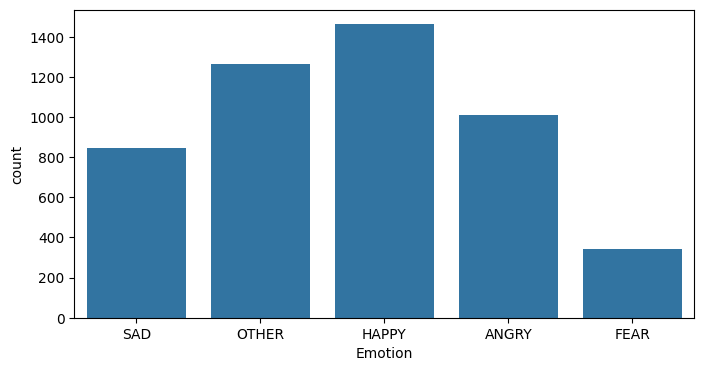

In [92]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=train_data);

In [100]:
# NULL values
print(train_data.isnull().sum())
print(train_data.duplicated().sum())

index = train_data[train_data.duplicated() == True].index
train_data.drop(index, axis = 0, inplace = True)
train_data.reset_index(inplace=True, drop = True)
print(train_data.shape)

Text       0
Emotion    0
dtype: int64
0
(4924, 2)


In [101]:
# print the rows which are duplicated (duplicated in the text but with different emotions)
train_data[train_data['Text'].duplicated() == True]

,Text,Emotion


In [95]:
#removing duplicated text
index = train_data[train_data['Text'].duplicated() == True].index
train_data.drop(index, axis = 0, inplace = True)
train_data.reset_index(inplace=True, drop = True)

In [96]:
# #Count the number of stopwords in the data
# persian_stopwords = set([
#     'و', 'در', 'به', 'از', 'که', 'را', 'این', 'است', 'با', 'برای', 'آن', 'یک', 'تا',
#     'اما', 'می', 'بر', 'نه', 'هم', 'یا', 'من', 'تو', 'او', 'ما', 'شما', 'آنها', 'باشد',
#     'خواهد', 'شود', 'کرد', 'کرده'
# ])

# temp =train_data.copy()
# temp['stop_words'] = temp['Text'].apply(
#     lambda x: len(set(str(x).split()) & persian_stopwords)
# )

# print(temp['stop_words'].value_counts())


#Count the number of stopwords in the data
from hazm import stopwords_list, Normalizer
import pandas as pd

# Use Hazm's built-in Persian stopwords
persian_stopwords = set(stopwords_list())

# Optional: normalize text to improve matching
normalizer = Normalizer()

# Copy original data
temp = train_data.copy()

# Count number of stopwords in each text row
temp['stop_words'] = temp['Text'].apply(
    lambda x: len(set(normalizer.normalize(str(x)).split()) & persian_stopwords)
)

# Display frequency counts
print(temp['stop_words'].value_counts())

stop_words
3     1090
2      994
4      820
1      689
5      531
6      303
0      254
7      142
8       53
9       36
10       8
11       4
Name: count, dtype: int64


<Axes: ylabel='Frequency'>

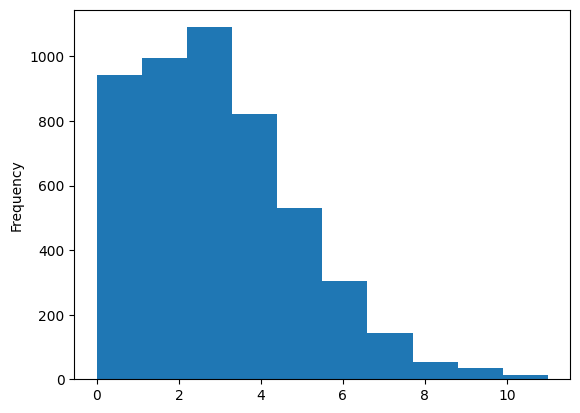

In [ ]:
#distribution of stopwords visually
temp['stop_words'].plot(kind= 'hist')

In [ ]:
#check if the data is balanced or not
test_data.Emotion.value_counts()

AttributeError: 'DataFrame' object has no attribute 'Emotion'

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=test_data);

In [ ]:
#print the number of null values in each column
print(test_data.isnull().sum())
#print the number of duplicated values
print(test_data.duplicated().sum())

In [ ]:
#print the rows which are duplicated
test_data[test_data['Text'].duplicated() == True]

In [ ]:
temp =test_data.copy()
temp['stop_words'] = temp['Text'].apply(
    lambda x: len(set(str(x).split()) & persian_stopwords)
)

print(temp['stop_words'].value_counts())

In [ ]:
sns.set(font_scale=1.3)
temp['stop_words'].plot(kind= 'hist')

In [ ]:
def dataframe_difference(df1, df2, which=None):
    """Find rows which are different between two DataFrames."""

    # Combine the two DataFrames using a merge operation, with the
    # indicator parameter set to True. This adds a column called _merge
    # to the resulting DataFrame, which indicates the source of each row.
    comparison_df = df1.merge(
        df2,
        indicator=True,
        how='outer'
    )

    # Filter the merged DataFrame based on the value of _merge. If which
    # is not specified, return all rows where _merge is not 'both'.
    # Otherwise, return all rows where _merge has the specified value
    if which is None:
        diff_df = comparison_df[comparison_df['_merge'] != 'both']
    else:
        diff_df = comparison_df[comparison_df['_merge'] == which]

    return diff_df

In [ ]:
dataframe_difference(train_data, test_data, which='both')

## Cleaning

In [ ]:
import re
import numpy as np

# Minimal Persian stopwords list (expand this as needed)
# persian_stopwords = set([
#     'و', 'در', 'به', 'از', 'که', 'را', 'این', 'است', 'با', 'برای', 'آن', 'یک', 'تا',
#     'اما', 'می', 'بر', 'نه', 'هم', 'یا', 'من', 'تو', 'او', 'ما', 'شما', 'آنها', 'باشد',
#     'خواهد', 'شود', 'کرد', 'کرده','ولی'
# ])

def remove_stop_words(text):
    words = [i for i in str(text).split() if i not in persian_stopwords]
    return " ".join(words)

def Removing_numbers(text):
    return ''.join([i for i in text if not i.isdigit()])

def lower_case(text):
    return " ".join([y.lower() for y in str(text).split()])

def Removing_punctuations(text):
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛', '')
    text = re.sub('\s+', ' ', text)  # remove extra whitespace
    return text.strip()

def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_small_sentences(df):
    df['Text'] = df['Text'].apply(lambda x: np.nan if len(str(x).split()) < 3 else x)

def normalize_text(df):
    df['Text'] = df['Text'].apply(lower_case)
    df['Text'] = df['Text'].apply(remove_stop_words)
    df['Text'] = df['Text'].apply(Removing_numbers)
    df['Text'] = df['Text'].apply(Removing_punctuations)
    df['Text'] = df['Text'].apply(Removing_urls)
    return df

def normalized_sentence(sentence):
    sentence = lower_case(sentence)
    sentence = remove_stop_words(sentence)
    sentence = Removing_numbers(sentence)
    sentence = Removing_punctuations(sentence)
    sentence = Removing_urls(sentence)
    return sentence


In [ ]:
train_data= normalize_text(train_data)
test_data= normalize_text(test_data)

## Modeling

In [ ]:
X_train = train_data['Text'].values
y_train = train_data['Emotion'].values

X_test = test_data['Text'].values
y_test = test_data['Emotion'].values

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

In [ ]:
# Encode labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

In [ ]:
# Vectorize training data first
from imblearn.over_sampling import SMOTE
tfidf = TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=5, max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)

# Apply SMOTE on vectorized data
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_tfidf, y_train_encoded)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
def train_model(model, data, targets):
    """
    Train a model on the given data and targets.

    Parameters:
    model (sklearn model): The model to be trained.
    data (list of str): The input data.
    targets (list of str): The targets.

    Returns:
    Pipeline: The trained model as a Pipeline object.
    """
    # Create a Pipeline object with a TfidfVectorizer and the given model
    text_clf = Pipeline([
        ('clf', model)
    ])
    text_clf.fit(data, targets)
    return text_clf

In [ ]:
from sklearn.metrics import f1_score
def get_F1(true,pred):
    """
    Get the F1 score for the given model on the given data and targets.

    Parameters:
    trained_model (sklearn model): The trained model.
    X (list of str): The input data.
    y (list of str): The targets.

    Returns:
    array: The F1 score for each class.
    """
    # Calculate the F1 score for the predictions
    return f1_score(true, pred, average='weighted')

In [ ]:
log_reg = train_model(
    LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced', random_state=0),
    X_train_resampled,
    y_train_resampled
)

X_test_tfidf = tfidf.transform(X_test)


In [ ]:
#test the model with the test data
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
y_pred_lr = log_reg.predict(X_test_tfidf)

#calculate the accuracy
log_reg_accuracy = accuracy_score(y_test_encoded, y_pred_lr)
print('Accuracy: ', log_reg_accuracy,'\n')

#calculate the F1 score
f1_lr = get_F1(y_test_encoded, y_pred_lr)
pd.DataFrame(f1_lr, index=le.classes_, columns=['F1 score'])

In [ ]:
print(classification_report(y_test_encoded, y_pred_lr, target_names=le.classes_))

In [ ]:
#Train the model with the training data
X_train_tfidf_orig = tfidf.transform(X_train)
DT = train_model(DecisionTreeClassifier(random_state=0), X_train_tfidf_orig, y_train_encoded)
#test the model with the test data
y_pred_dt = DT.predict(X_test_tfidf)

#calculate the accuracy
DT_accuracy =accuracy_score(y_test_encoded, y_pred_dt)
print('Accuracy: ', DT_accuracy,'\n')

#calculate the F1 score
f1_dt = get_F1(y_test_encoded, y_pred_dt)
pd.DataFrame(f1_dt, index=le.classes_, columns=['F1 score'])

In [ ]:
##Classification Report
print(classification_report(y_test_encoded, y_pred_dt, target_names=le.classes_))

In [ ]:
#Train the model with the training data
SVM = train_model(SVC(C=1.0, kernel='linear', probability=True,class_weight='balanced'), X_train_tfidf, y_train_encoded)

#test the model with the test data
y_pred_svm = SVM.predict(X_test_tfidf)

#calculate the accuracy
SVM_accuracy = accuracy_score(y_test_encoded, y_pred_svm)
print('Accuracy: ', SVM_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(y_test_encoded, y_pred_svm)
pd.DataFrame(f1_Score, index=le.classes_, columns=['F1 score'])

In [ ]:
##Classification Report
print(classification_report(y_test_encoded, y_pred_svm, target_names=le.classes_))

In [ ]:
#Train the model with the training data
RF =train_model(RandomForestClassifier(n_estimators=200, max_depth=50, class_weight='balanced'), X_train_tfidf, y_train_encoded)

#test the model with the test data
y_pred_rf = RF.predict(X_test_tfidf)

#calculate the accuracy
RF_accuracy = accuracy_score(y_test_encoded, y_pred_rf)
print('Accuracy: ', RF_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(y_test_encoded, y_pred_rf)
pd.DataFrame(f1_Score, index=le.classes_, columns=['F1 score'])

In [ ]:
##Classification Report
print(classification_report(y_test_encoded, y_pred_rf, target_names=le.classes_))

In [ ]:
import xgboost as xgb
# =(RandomForestClassifier(n_estimators=200, max_depth=50, class_weight='balanced'), X_train_tfidf, y_train_encoded)

XGB = train_model(xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=0),X_train_resampled, y_train_resampled)
# xgb_clf.fit()
y_pred_XGB = XGB.predict(X_test_tfidf)
XGB_accuracy = accuracy_score(y_test_encoded, y_pred_XGB)
print('Accuracy: ', XGB_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(y_test_encoded, y_pred_XGB)
pd.DataFrame(f1_Score, index=le.classes_, columns=['F1 score'])

In [ ]:
##Classification Report
print(classification_report(y_test_encoded, y_pred_XGB, target_names=le.classes_))

In [ ]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Support Vector Machine', 'Random Forest', 'XGBoost'],
    'Accuracy': [
        round(log_reg_accuracy, 2),
        round(DT_accuracy, 2),
        round(SVM_accuracy, 2),
        round(RF_accuracy, 2),
        round(XGB_accuracy, 2)
    ],    'F1 Score (Weighted)': [
        round(get_F1(y_test_encoded, y_pred_lr), 2),
        round(get_F1(y_test_encoded, y_pred_dt), 2),
        round(get_F1(y_test_encoded, y_pred_svm), 2),
        round(get_F1(y_test_encoded, y_pred_rf), 2),
        round(get_F1(y_test_encoded, y_pred_XGB), 2)
    ]
})
models_sorted = models.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
models_sorted


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # for LogisticRegression or SVM
    'max_iter': [1000, 2000],
    'solver': ['liblinear', 'saga'],
}

grid = GridSearchCV(LogisticRegression(class_weight='balanced', random_state=0), param_grid, cv=5, scoring='f1_weighted')
grid.fit(X_train_resampled, y_train_resampled)

print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)


In [ ]:
best_model_name = models_sorted.loc[0, 'Model']  # gets model with highest accuracy
print("Best model is:", best_model_name)

## LIME

In [ ]:
#c_LR = make_pipeline(tfidf, clf)
from sklearn.pipeline import make_pipeline
idx  = 2
RF_pipeline = make_pipeline(tfidf, SVM.named_steps['clf'])
pred_label = le.inverse_transform(RF_pipeline.predict([X_test[idx]]))[0]
actual_label = y_test[idx]  # already a string

explainer_LR = LimeTextExplainer(class_names=le.classes_)
print("Actual Text : ", X_test[idx])
print("Prediction : ", pred_label)
print("Actual     : ", actual_label)

exp = explainer_LR.explain_instance(X_test[idx], RF_pipeline.predict_proba, top_labels=5)
exp.show_in_notebook()


In [ ]:
#Splitting the text from the labels
X_train = train_data['Text']
y_train = train_data['Emotion']

X_test = test_data['Text']
y_test = test_data['Emotion']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

In [ ]:
# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)
print(set(y_train))

In [ ]:
#Convert the class vector (integers) to binary class matrix
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

print(y_train)

## Tokenizing

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))

tokenizer.document_count

In [ ]:
#converting a single sentence to list of indexes
tokenizer.texts_to_sequences([X_train.iloc[0]])

#convert the list of indexes into a matrix of ones and zeros (BOW)
tokenizer.texts_to_matrix(X_train[0].split())

#the sentence contains three words and the size of the vocabulary is 14325
tokenizer.texts_to_matrix(X_train[0].split()).shape

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

## Padding

In [ ]:
test_data.shape

In [ ]:
maxlen = max([len(t) for t in train_data['Text']])
maxlen

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
maxlen = max(len(seq) for seq in sequences_train)

X_train = pad_sequences(sequences_train, maxlen=maxlen, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=maxlen, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=maxlen, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

In [ ]:
#before
sequences_train[0]

In [ ]:
#after
X_train[0]

## Word Embedding

In [ ]:
# Read GloVE embeddings

path_to_glove_file = '/Users/macbookpro/Downloads/glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200 #latent factors or features
hits = 0
misses = 0
embeddings_index = {}

In [ ]:
# Read word vectors
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

In [ ]:
# Build neural network architecture
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

adam = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(vocabSize, 200, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(256, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

In [ ]:
import tensorflow as tf
model.build(input_shape=(None, 100))
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
#to stop the training when the loss starts to increase
callback = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
)

In [ ]:
# test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
# print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

In [ ]:
# # Evaluate on validation set
# val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)
# print(f"\nValidation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

In [ ]:
predicted = model.predict(X_test)
y_pred = predicted.argmax(axis=-1)
print("\nClassification Report:")
print(classification_report(le.transform(test_data['Emotion']), y_pred, target_names=le.classes_))


In [ ]:
# # Fit model
# history = model.fit(X_train,
#                     y_train,
#                     validation_data=(X_val, y_val),
#                     verbose=1,
#                     batch_size=256,
#                     epochs=30,
#                     callbacks=[callback]
#                    )

In [ ]:
#print the overall loss and accuracy
model.evaluate(X_val, y_val, verbose=1)

In [ ]:
# #print the overall loss and accuracy
# model.evaluate(X_test, y_test, verbose=1)

In [ ]:
# predicted = model.predict(X_test)
# y_pred = predicted.argmax(axis=-1)

# print(classification_report(le.transform(test_data['Emotion']), y_pred))

In [ ]:
# # Visualize Loss & Accuracy

# %matplotlib inline
# import matplotlib.pyplot as plt
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs = range(len(acc))

# plt.plot(epochs, acc, 'r', label='Training accuracy')
# plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
# plt.title('Training and validation accuracy')
# plt.legend()
# plt.figure()

# plt.plot(epochs, loss, 'r', label='Training Loss')
# plt.plot(epochs, val_loss, 'b', label='Validation Loss')
# plt.title('Training and validation loss')
# plt.legend()

# plt.show()

In [ ]:
# Classify custom sample

sentences = [
            "مرگ پایان زندگی من است",
            'شاید مرگ پایان روح ما نباشه ولی پایان جسم ماست',
            "مرگ به پایان زندگی محدود نمیشه",
            "اه تف به این زندگی"
            ]
for sentence in sentences:
    print(sentence)
    sentence = normalized_sentence(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

In [ ]:
sentence= 'شاید مرگ پایان روح ما نباشه ولی پایان جسم ماست'
print(sentence)
sentence = normalized_sentence(sentence)
sentence = tokenizer.texts_to_sequences([sentence])
sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
proba =  np.max(model.predict(sentence))
print(f"{result} : {proba}\n\n")

# OLD section

In [ ]:
import hazm
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import re

In [ ]:
train_url = "train_data.csv"
test_url = "test.tsv"

# Load the datasets
train_df = pd.read_csv("train_data.csv", header=None)
test_df = pd.read_csv(test_url, sep='\t', header=None)

train_df.drop(0,inplace=True)
train_df.columns = ['text', 'label']
# test_df.columns = ['text', 'label']

## EDA

In [ ]:
train_df.head()

In [ ]:
train_df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
train_df['text_length'] = train_df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(train_df['text_length'], bins=50, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length (words)')
plt.ylabel('Frequency')
plt.xlim(0, 100)  # Zoom in to texts with length up to 100 words
plt.grid(True)
plt.show()

## remove null values and duplicates

In [ ]:
print(train_df.isnull().sum())
print(train_df.duplicated().sum())

index = train_df[train_df.duplicated() == True].index
train_df.drop(index, axis = 0, inplace = True)
train_df.reset_index(inplace=True, drop = True)
print(train_df.shape)

In [ ]:
index = train_df[train_df['text'].duplicated() == True].index
train_df.drop(index, axis = 0, inplace = True)
train_df.reset_index(inplace=True, drop = True)
print(train_df.shape)

## cleaning the texts

In [ ]:
import gdown
from hazm import stopwords_list

url = 'https://drive.google.com/uc?id=1Q3JK4NVUC2t5QT63aDiVrCRBV225E_B3'
output = 'postagger.model'
gdown.download(url, output, quiet=False)

from hazm import POSTagger
pos_tagger = POSTagger(model='postagger.model')

In [ ]:
stopwords = set(stopwords_list())

def avg_word_length(text):
    words = text.split()
    if len(words) == 0:
        return 0
    return sum(len(w) for w in words) / len(words)

def count_punctuations(text):
    return len(re.findall(r'[^\w\s]', text))

def count_stopwords(text):
    return sum(1 for word in text.split() if word in stopwords)

def contains_url(text):
    return bool(re.search(r'https?://\S+|www\.\S+', text))

def pos_counts(text_tokens):
    tags = pos_tagger.tag(text_tokens)
    counts = {'NOUN': 0, 'VERB': 0, 'ADJ': 0}
    for _, tag in tags:
        if tag in counts:
            counts[tag] += 1
    return counts

In [ ]:
normalizer = hazm.Normalizer()

In [ ]:
train_df['text'] = train_df['text'].apply(normalizer.decrease_repeated_chars)

In [ ]:
train_df['text'] = train_df['text'].apply(normalizer.persian_number)

In [ ]:
train_df['text'] = train_df['text'].apply(normalizer.remove_diacritics)

In [ ]:
train_df['text'] = train_df['text'].apply(normalizer.correct_spacing)

In [ ]:
train_df['text'] = train_df['text'].apply(normalizer.normalize)

In [ ]:
train_df['num_words'] = train_df['text'].apply(lambda x: len(x.split()))
train_df['num_chars'] = train_df['text'].apply(len)
train_df['avg_word_len'] = train_df['text'].apply(avg_word_length)
train_df['num_punctuations'] = train_df['text'].apply(count_punctuations)
train_df['stopword_ratio'] = train_df['text'].apply(count_stopwords) / (train_df['num_words'] + 1e-6)
train_df['has_url'] = train_df['text'].apply(contains_url).astype(int)

In [ ]:
def remove_chars(text):
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛', '')
    text = re.sub('\s+', ' ', text)  # remove extra whitespace
    return text.strip()

train_df['text'] = train_df['text'].apply(remove_chars)

In [ ]:
def Removing_urls_http(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)
train_df['text'] = train_df['text'].apply(Removing_urls_http)

## Feature engineering

In [ ]:
le = preprocessing.LabelEncoder()
encoded_labels = le.fit_transform(train_df['label'])
train_df['label_decoded'] = encoded_labels

In [ ]:
tokenizer = hazm.WordTokenizer()
train_df['text'] = train_df['text'].apply(tokenizer.tokenize)

In [ ]:
def remove_stopwords(text):
    return [word for word in text if word not in stopwords]

train_df['text'] = train_df['text'].apply(remove_stopwords)

In [ ]:
lemmatizer = hazm.Lemmatizer()

def safe_lemmatize_tokens(tokens):
    lemmatized = []
    for token in tokens:
        try:
            lemma = lemmatizer.lemmatize(token)
            lemmatized.append(lemma)
        except Exception as e:
            print(f"Error lemmatizing token: {token} — {e}")
            # lemmatized.append(token)  # fallback to the original token
    return lemmatized

train_df['text'] = train_df['text'].apply(safe_lemmatize_tokens)

In [ ]:
def embed2string(list):
    return ' '.join(word for word in list)

In [ ]:
train_df['text'] = train_df['text'].apply(normalizer.token_spacing)

In [ ]:
train_df['text'] = train_df['text'].apply(embed2string)

In [ ]:
train_df['text'] = train_df['text'].apply(remove_chars)

In [ ]:
train_df['text'] = train_df['text'].apply(tokenizer.tokenize)

In [ ]:
pos_features = train_df['text'].apply(pos_counts).apply(pd.Series)
train_df['num_nouns'] = pos_features['NOUN']
train_df['num_verbs'] = pos_features['VERB']
train_df['num_adjs'] = pos_features['ADJ']
train_df.head()

#### word2vec

In [ ]:
from huggingface_hub import hf_hub_download

# Download the file to a local path
model_path = hf_hub_download(
    repo_id="taesiri/PersianWordVecs",
    filename="farsi-dedup-cbow.bin"
)
import fasttext
model = fasttext.load_model(model_path)

In [ ]:
neighbors = model.get_nearest_neighbors('سگ', k=10)
for score, word in neighbors:
    print(f"{word} → {score:.4f}")

In [ ]:
def get_sentence_embedding(sentence, model):
    words = sentence
    word_vectors = [model.get_word_vector(word) for word in words if word.strip()]
    if not word_vectors:
        return np.zeros(model.get_dimension())  # fallback for empty input
    return np.mean(word_vectors, axis=0)

In [ ]:
# --- Step 1: Generate sentence embeddings (X_train) ---
X_train = np.vstack(train_df['text'].apply(lambda x: get_sentence_embedding(x, model)).values)

# --- Step 2: Prepare target array (y_train) ---
y_train = train_df['label_decoded'].values

# --- Step 3: Drop unused label column ---
train_df.drop(['label','text','label_decoded'], axis=1, inplace=True)

# --- Step 5: Convert embedding array to DataFrame ---
X_embed_df = pd.DataFrame(X_train, columns=[f'emb_{i}' for i in range(X_train.shape[1])])

# --- Step 6: Reset indices to align DataFrames ---
train_df.reset_index(drop=True, inplace=True)
X_embed_df.reset_index(drop=True, inplace=True)

# --- Step 7: Concatenate handcrafted and embedding features ---
X_full_train = pd.concat([train_df, X_embed_df], axis=1)
X_full_train.head()

In [ ]:
from sklearn.model_selection import train_test_split

# --- Step 8: Train-test split ---
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_full_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Train shape: {X_train_split.shape}, Validation shape: {X_val_split.shape}")


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert DataFrames and arrays to tensors
train_dataset = TensorDataset(
    torch.tensor(X_train_split.values, dtype=torch.float32),
    torch.tensor(y_train_split, dtype=torch.long)
)

val_dataset = TensorDataset(
    torch.tensor(X_val_split.values, dtype=torch.float32),
    torch.tensor(y_val_split, dtype=torch.long)
)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=128, drop_last=False)

In [ ]:
class FixedResidualMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()

        # Initial projection to hidden space
        self.input_proj = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU()
        )

        # Residual blocks with proper identity mapping
        self.res_blocks = nn.ModuleList([
            ResidualBlock(hidden_dim),
            ResidualBlock(hidden_dim)
        ])

        # Classifier head
        self.classifier = nn.Linear(hidden_dim, num_classes)

        # Proper initialization
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_proj(x)

        # Apply residual blocks
        for block in self.res_blocks:
            x = block(x)

        return self.classifier(x)


class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        # No need for projection - same dimension
        self.shortcut = nn.Identity()

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.net(x)
        return out + residual  # Clean residual connection

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import f1_score,accuracy_score
import time

model_mlp = FixedResidualMLP(
    input_dim=110,
    hidden_dim=128,
    num_classes=len(set(y_train)),
).to(device)

optimizer = torch.optim.Adam(
    model_mlp.parameters(),
    lr=1e-3,           # Start with standard LR
    weight_decay=1e-4  # L2 regularization
)

# 3. SCHEDULER - NO WARM RESTARTS (they're destabilizing)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=10,
    gamma=0.5  # Halve LR every 10 epochs
)

test_losses_epoch = []
train_losses_epoch = []
val_f1_scores = []
val_acc_scores = []
val_losses_epoch = []

num_epochs = 30
clip_value = 1.0  # for gradient clipping

for epoch in range(num_epochs):
    start_time = time.time()

    model_mlp.train()
    train_losses = []

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        out = model_mlp(xb)
        loss = criterion(out, yb)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_mlp.parameters(), max_norm=clip_value)
        optimizer.step()

        train_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)
    train_losses_epoch.append(avg_train_loss)

    # Validation
    model_mlp.eval()
    preds, targets = [], []
    val_losses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            outputs = model_mlp(xb)
            preds.extend(outputs.argmax(dim=1).cpu().numpy())
            targets.extend(yb.numpy())
            val_losses.append(loss.item())

            preds.extend(outputs.argmax(dim=1).cpu().numpy())
            targets.extend(yb.cpu().numpy())

    avg_val_loss = np.mean(val_losses)
    val_losses_epoch.append(avg_val_loss)

    f1 = f1_score(targets, preds, average='macro')
    accuracy = accuracy_score(targets, preds)
    val_f1_scores.append(f1)
    val_acc_scores.append(accuracy)

    scheduler.step()
    duration = time.time() - start_time

    print(f"--- Epoch {epoch+1}/{num_epochs} ---")
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val F1 Score: {f1:.4f}| Val Acc Score: {accuracy:.4f} | Time: {duration:.2f}s")

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_epoch, label='Train Loss')
plt.plot(val_losses_epoch, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_f1_scores, label='Validation F1 Score', color='green')
plt.plot(val_acc_scores,label='Validation Accuracy Score',color='orange')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Validation F1 Score per Epoch')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# For training
X_train_np = train_dataset.tensors[0].cpu().numpy()  # features
y_train_np = train_dataset.tensors[1].cpu().numpy()  # labels

# For validation
X_val_np = val_dataset.tensors[0].cpu().numpy()
y_val_np = val_dataset.tensors[1].cpu().numpy()


In [ ]:
import xgboost as xgb
from sklearn.metrics import f1_score

model_xgb = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y_train_np)),
    use_label_encoder=False,
    random_state=42,
    n_estimators=400,
    max_depth=20,
    learning_rate=0.5
)

model_xgb.fit(X_train_np, y_train_np, eval_set=[(X_val_np, y_val_np)], verbose=True)

y_pred = model_xgb.predict(X_val_np)
f1 = f1_score(y_val_np, y_pred, average='macro')
print(f"XGB Validation F1 Score: {f1:.4f}")


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_np, y_train_np)
y_pred = rf.predict(X_val_np)
f1 = f1_score(y_val_np, y_pred, average='macro')
print(f"Random Forest Validation F1 Score: {f1:.4f}")


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

X_train_np = train_dataset.tensors[0].cpu().numpy()
y_train_np = train_dataset.tensors[1].cpu().numpy()
X_val_np = val_dataset.tensors[0].cpu().numpy()
y_val_np = val_dataset.tensors[1].cpu().numpy()

model_lr = LogisticRegression(max_iter=1000, random_state=42)
model_lr.fit(X_train_np, y_train_np)

y_pred = model_lr.predict(X_val_np)
f1 = f1_score(y_val_np, y_pred, average='macro')
print(f"Logistic Regression Validation F1 Score: {f1:.4f}")

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score

X_train_np = train_dataset.tensors[0].cpu().numpy()
y_train_np = train_dataset.tensors[1].cpu().numpy()
X_val_np = val_dataset.tensors[0].cpu().numpy()
y_val_np = val_dataset.tensors[1].cpu().numpy()

model_svm = SVC(kernel='rbf', probability=True, random_state=42)
model_svm.fit(X_train_np, y_train_np)

y_pred = model_svm.predict(X_val_np)
f1 = f1_score(y_val_np, y_pred, average='macro')
print(f"SVM Validation F1 Score: {f1:.4f}")

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score

X_train_np = train_dataset.tensors[0].cpu().numpy()
y_train_np = train_dataset.tensors[1].cpu().numpy()
X_val_np = val_dataset.tensors[0].cpu().numpy()
y_val_np = val_dataset.tensors[1].cpu().numpy()

model_gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
model_gb.fit(X_train_np, y_train_np)

y_pred = model_gb.predict(X_val_np)
f1 = f1_score(y_val_np, y_pred, average='macro')
print(f"Gradient Boosting Validation F1 Score: {f1:.4f}")


#### TF IDF

In [ ]:
vectorizer = TfidfVectorizer()
vector = vectorizer.fit_transform(train_x['text'])
train_x = pd.DataFrame(vector.toarray(), columns=vectorizer.get_feature_names_out(), index=train_x.index)

In [ ]:
[train_x.shape,train_y.shape]

In [ ]:
test_df['text'] = test_df['text'].apply(normalizer.decrease_repeated_chars)
test_df['text'] = test_df['text'].apply(normalizer.persian_number)
test_df['text'] = test_df['text'].apply(normalizer.remove_diacritics)
test_df['text'] = test_df['text'].apply(normalizer.correct_spacing)
test_df['text'] = test_df['text'].apply(normalizer.normalize)
test_df['text'] = test_df['text'].apply(remove_stopwords)
test_df['text'] = test_df['text'].apply(remove_chars)
test_df['text'] = test_df['text'].apply(Removing_urls_http)
test_df['text'] = test_df['text'].apply(lemmatizer.lemmatize)

In [ ]:
test_df['text'] = test_df['text'].apply(tokenizer.tokenize)
test_df['text'] = test_df['text'].apply(normalizer.token_spacing)
test_df['text'] = test_df['text'].apply(embed2string)

encoded_labels = le.transform(test_df['label'])
test_df['label_decoded'] = encoded_labels

In [ ]:
test_x = test_df.drop('label_decoded', axis=1)
test_y = test_df['label_decoded']

In [ ]:
vector2 = vectorizer.transform(test_x['text'])
test_x = pd.DataFrame(vector2.toarray(), columns=vectorizer.get_feature_names_out(), index=test_x.index)

## training

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier,VotingClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_x)
pca = PCA(n_components=2000)
train_x = pca.fit_transform(X_scaled)

X_scaled2 = scaler.transform(test_x)
test_x = pca.transform(X_scaled2)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,f1_score

def evaluate(model,Xtrain,Ytrain,Xtest,Ytest):
    # Assume y_test are the true labels and y_pred are the predicted labels
    model.fit(Xtrain,Ytrain)
    y_train_pred = model.predict(Xtrain)
    y_test_pred = model.predict(Xtest)

    print("train report")
    accuracy_train = accuracy_score(Ytrain, y_train_pred)
    print(f"Accuracy: {accuracy_train}")
    weighted_f1_train = f1_score(Ytrain, y_train_pred, average='weighted')
    print(f'Weighted-average F1 Score: {weighted_f1_train}')

    # Confusion Matrix
    cm = confusion_matrix(Ytrain, y_train_pred)
    plt.figure(figsize=(5, 4)) # Set the figure size
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_) # Create a heatmap from the confusion matrix
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Precision, Recall, F1-score
    report = classification_report(Ytrain, y_train_pred, output_dict=True)
    colors = ['#ffdfdf', '#dfffff', '#dfffdf', '#dfdfff', '#ffdfff', '#ffffdf']  # Adjust colors as needed

    # Prepare data for plotting
    metrics = ['precision', 'recall', 'f1-score', 'support']
    data = {metric: [] for metric in metrics}
    labels = []

    # Populate data with class-specific metrics
    for cls, metrics_values in report.items():
      if cls.isdigit():
          labels.append(le.classes_[int(cls)])
          for metric in metrics:
              data[metric].append(metrics_values.get(metric, None))
      elif cls in ['macro avg', 'weighted avg']:
          labels.append(cls)
          for metric in metrics:
              data[metric].append(metrics_values.get(metric, None))


    # Convert data to DataFrame
    df3 = pd.DataFrame(data, index=labels)

    # Create subplots for each metric
    fig, axes = plt.subplots(1, len(metrics), figsize=(20, 6), sharey=True)
    for ax, metric in zip(axes, metrics):
        sns.barplot(hue=df3.index, y=metric, data=df3, ax=ax, legend=False)
        ax.set_title(f'{metric.capitalize()} by Class')
        ax.set_ylim(0, 1.1)

    plt.suptitle(f'classification report for {model.__class__.__name__} ', fontsize=16)
    plt.tight_layout()
    plt.show()

    print("\n\n\ntest report")
    accuracy_test = accuracy_score(Ytest, y_test_pred)
    print(f"Accuracy: {accuracy_test}")
    weighted_f1_test = f1_score(Ytest, y_test_pred, average='weighted')
    print(f'Weighted-average F1 Score: {weighted_f1_test}')

    # Confusion Matrix
    cm = confusion_matrix(Ytest, y_test_pred)

    plt.figure(figsize=(5, 4)) # Set the figure size
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_) # Create a heatmap from the confusion matrix
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    # Precision, Recall, F1-score
    report = classification_report(Ytrain, y_train_pred, output_dict=True)

    colors = ['#ffdfdf', '#dfffff', '#dfffdf', '#dfdfff', '#ffdfff', '#ffffdf']  # Adjust colors as needed

    # Prepare data for plotting
    metrics = ['precision', 'recall', 'f1-score', 'support']
    data = {metric: [] for metric in metrics}
    labels = []

    # Populate data with class-specific metrics
    for cls, metrics_values in report.items():
      if cls.isdigit():
          labels.append(le.classes_[int(cls)])
          for metric in metrics:
              data[metric].append(metrics_values.get(metric, None))
      elif cls in ['macro avg', 'weighted avg']:
          labels.append(cls)
          for metric in metrics:
              data[metric].append(metrics_values.get(metric, None))


    # Convert data to DataFrame
    df3 = pd.DataFrame(data, index=labels)

    # Create subplots for each metric
    fig, axes = plt.subplots(1, len(metrics), figsize=(20, 6), sharey=True)
    for ax, metric in zip(axes, metrics):
        sns.barplot(hue=df3.index, y=metric, data=df3, ax=ax, legend=False)
        ax.set_title(f'{metric.capitalize()} by Class')
        ax.set_ylim(0, 1.1)

    plt.suptitle(f'classification report for {model.__class__.__name__} ', fontsize=16)
    plt.tight_layout()
    plt.show()

    return {"model": model.__class__.__name__, "f1 train": weighted_f1_train, "accuracy train": weighted_f1_train, "f1 test": weighted_f1_test, "accuracy test": weighted_f1_test}

In [ ]:
model = LogisticRegression(random_state=42, solver='saga')
evaluate(model,train_x,train_y,test_x,test_y)

In [ ]:
model = svm.SVC(C= 1, kernel='rbf')
evaluate(model,train_x,train_y,test_x,test_y)